In [ ]:
!pip install torch-lucent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 743.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-many

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import re
import numpy as np
import multiprocessing as mp
import pandas as pd
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import pickle

## Lucent
import lucent
from lucent.optvis import render

import matplotlib.pyplot as plt


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip -d /content/

URL transformed to HTTPS due to an HSTS policy
--2024-05-30 12:44:59--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.38MB/s    in 30s     

2024-05-30 12:45:30 (7.78 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]



In [ ]:
# Configures the device for PyTorch operations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# Set the start method for multiprocessing
mp.set_start_method('spawn', force=True)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the path to your dataset folder
data_dir = '/content/tiny-imagenet-200/'

# Custom numerical sort function
def numerical_sort(value):
    numbers = re.findall(r'\d+', value)
    return list(map(int, numbers))

# Load the training dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)

# Sort the samples numerically
train_dataset.samples.sort(key=lambda x: numerical_sort(x[0]))

# Create a mapping from file paths to original image names and true labels
path_to_image_name_and_label = {sample_path: (os.path.basename(sample_path).split('.')[0], label) for sample_path, label in train_dataset.samples}

# Load pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in Tiny ImageNet (200 classes)
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

# Active Learning Parameters
num_loops = 10
samples_per_loop = 10000

# Randomly select the initial 10000 samples
initial_indices = np.random.choice(len(train_dataset), samples_per_loop, replace=False)
current_indices = initial_indices.tolist()
remaining_indices = list(set(range(len(train_dataset))) - set(current_indices))

# Create a reverse mapping from index to original image names and true labels for all indices
index_to_image_name_and_label = {idx: path_to_image_name_and_label[train_dataset.samples[idx][0]] for idx in range(len(train_dataset))}

for loop in range(num_loops):
    print(f"Starting loop {loop + 1}/{num_loops}...")

    # Create DataLoaders for current training set and validation set
    train_loader = DataLoader(Subset(train_dataset, current_indices), batch_size=128, shuffle=True, num_workers=8)

    # Train the model on the current set
    model.train()
    for epoch in range(20):  # Train for 20 epochs per loop
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        print(f'Loop {loop + 1}/{num_loops}, Epoch {epoch+1}/20, Loss: {running_loss/len(train_loader)}')

    # Evaluate the model to select new samples and save inference data
    model.eval()
    uncertainties = []
    inference_data = []

    with torch.no_grad():
        for idx, (inputs, _) in enumerate(DataLoader(Subset(train_dataset, remaining_indices), batch_size=128, shuffle=False, num_workers=8)):
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, preds = probs.max(dim=1)
            uncertainty = 1 - max_probs  # Calculate uncertainty as 1 - max probability
            uncertainties.extend(uncertainty.cpu().numpy())

            # Save inference data with original image names and true labels
            batch_indices = remaining_indices[idx*128:(idx+1)*128]  # Get the indices of the current batch
            for i in range(len(batch_indices)):
                original_image_name, true_label = index_to_image_name_and_label[batch_indices[i]]
                inference_data.append({
                    'original_image_name': original_image_name,
                    'true_label': true_label,
                    'prediction': preds[i].item(),
                    'confidence': max_probs[i].item()
                })

    # Save inference data to CSV
    df = pd.DataFrame(inference_data)
    df.to_csv(f'inference_data_loop_{loop+1}.csv', index=False)
    print(f'Saved inference data for loop {loop + 1} to inference_data_loop_{loop+1}.csv')

    # Select the 10000 samples with the highest uncertainty
    uncertainties = np.array(uncertainties)
    query_indices = np.argsort(uncertainties)[-samples_per_loop:].tolist()

    # Update the current and remaining indices
    new_indices = [remaining_indices[i] for i in query_indices]
    current_indices.extend(new_indices)
    remaining_indices = list(set(remaining_indices) - set(new_indices))

    print(f"Loop {loop + 1}/{num_loops} completed. Queried {samples_per_loop} new samples.")

# Save the final model
torch.save(model.state_dict(), 'alub.pth')
print(f'Model weights saved')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.2MB/s]


Starting loop 1/10...


Epoch 1/20: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Loop 1/10, Epoch 1/20, Loss: 3.9041395308096196


Epoch 2/20: 100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Loop 1/10, Epoch 2/20, Loss: 2.5680424050439763


Epoch 3/20: 100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


Loop 1/10, Epoch 3/20, Loss: 1.6975180106826975


Epoch 4/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 4/20, Loss: 0.990725619883477


Epoch 5/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 5/20, Loss: 0.4329862092869191


Epoch 6/20: 100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Loop 1/10, Epoch 6/20, Loss: 0.15671249111241933


Epoch 7/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 7/20, Loss: 0.0729568434195428


Epoch 8/20: 100%|██████████| 79/79 [00:28<00:00,  2.80it/s]


Loop 1/10, Epoch 8/20, Loss: 0.053819668986186196


Epoch 9/20: 100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


Loop 1/10, Epoch 9/20, Loss: 0.013490901293256615


Epoch 10/20: 100%|██████████| 79/79 [00:27<00:00,  2.83it/s]


Loop 1/10, Epoch 10/20, Loss: 0.006760731763854812


Epoch 11/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 11/20, Loss: 0.0030048040767447857


Epoch 12/20: 100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


Loop 1/10, Epoch 12/20, Loss: 0.002116856695730475


Epoch 13/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 13/20, Loss: 0.0020156511093808124


Epoch 14/20: 100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Loop 1/10, Epoch 14/20, Loss: 0.0216813415194614


Epoch 15/20: 100%|██████████| 79/79 [00:27<00:00,  2.83it/s]


Loop 1/10, Epoch 15/20, Loss: 0.21205205467965785


Epoch 16/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 16/20, Loss: 1.4743355595612828


Epoch 17/20: 100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


Loop 1/10, Epoch 17/20, Loss: 0.5277190598883207


Epoch 18/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Loop 1/10, Epoch 18/20, Loss: 0.1302567503733348


Epoch 19/20: 100%|██████████| 79/79 [00:27<00:00,  2.83it/s]


Loop 1/10, Epoch 19/20, Loss: 0.01722301420154451


Epoch 20/20: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]

Loop 1/10, Epoch 20/20, Loss: 0.009130148936204518



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Saved inference data for loop 1 to inference_data_loop_1.csv
Loop 1/10 completed. Queried 10000 new samples.
Starting loop 2/10...


Epoch 1/20: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


Loop 2/10, Epoch 1/20, Loss: 2.590433711458923


Epoch 2/20: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


Loop 2/10, Epoch 2/20, Loss: 1.0766440535047253


Epoch 3/20: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


Loop 2/10, Epoch 3/20, Loss: 0.2763618628025814


Epoch 4/20: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


Loop 2/10, Epoch 4/20, Loss: 0.037333319622097884


Epoch 5/20: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


Loop 2/10, Epoch 5/20, Loss: 0.006217616242445578


Epoch 6/20: 100%|██████████| 157/157 [00:34<00:00,  4.60it/s]


Loop 2/10, Epoch 6/20, Loss: 0.002719417872844608


Epoch 7/20: 100%|██████████| 157/157 [00:33<00:00,  4.64it/s]


Loop 2/10, Epoch 7/20, Loss: 0.0020911362745864377


Epoch 8/20: 100%|██████████| 157/157 [00:34<00:00,  4.61it/s]


Loop 2/10, Epoch 8/20, Loss: 0.0016232364615247508


Epoch 9/20: 100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


Loop 2/10, Epoch 9/20, Loss: 0.0013751988684770407


Epoch 10/20: 100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


Loop 2/10, Epoch 10/20, Loss: 0.0012039828298103278


Epoch 11/20: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


Loop 2/10, Epoch 11/20, Loss: 0.0010439126283689668


Epoch 12/20: 100%|██████████| 157/157 [00:33<00:00,  4.66it/s]


Loop 2/10, Epoch 12/20, Loss: 0.0009403803035806698


Epoch 13/20: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


Loop 2/10, Epoch 13/20, Loss: 0.0008578506078879544


Epoch 14/20: 100%|██████████| 157/157 [00:33<00:00,  4.68it/s]


Loop 2/10, Epoch 14/20, Loss: 0.0007294036068354443


Epoch 15/20: 100%|██████████| 157/157 [00:33<00:00,  4.68it/s]


Loop 2/10, Epoch 15/20, Loss: 0.0007047499559677331


Epoch 16/20: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


Loop 2/10, Epoch 16/20, Loss: 0.0007116435819370732


Epoch 17/20: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


Loop 2/10, Epoch 17/20, Loss: 0.0006206293833578468


Epoch 18/20: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


Loop 2/10, Epoch 18/20, Loss: 0.0005154023124913502


Epoch 19/20: 100%|██████████| 157/157 [00:33<00:00,  4.64it/s]


Loop 2/10, Epoch 19/20, Loss: 0.00048093018448276887


Epoch 20/20: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]

Loop 2/10, Epoch 20/20, Loss: 0.0004980518381781639


Saved inference data for loop 2 to inference_data_loop_2.csv
Loop 2/10 completed. Queried 10000 new samples.
Starting loop 3/10...


Epoch 1/20: 100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Loop 3/10, Epoch 1/20, Loss: 3.3724398435430323


Epoch 2/20: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


Loop 3/10, Epoch 2/20, Loss: 1.5835030926034805


Epoch 3/20: 100%|██████████| 235/235 [00:39<00:00,  5.90it/s]


Loop 3/10, Epoch 3/20, Loss: 0.4330488012192097


Epoch 4/20: 100%|██████████| 235/235 [00:39<00:00,  5.91it/s]


Loop 3/10, Epoch 4/20, Loss: 0.06470104627152706


Epoch 5/20: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]


Loop 3/10, Epoch 5/20, Loss: 0.008956926700441127


Epoch 6/20: 100%|██████████| 235/235 [00:39<00:00,  5.90it/s]


Loop 3/10, Epoch 6/20, Loss: 0.0033517678307884552


Epoch 7/20: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


Loop 3/10, Epoch 7/20, Loss: 0.0022669197397029144


Epoch 8/20: 100%|██████████| 235/235 [00:39<00:00,  5.91it/s]


Loop 3/10, Epoch 8/20, Loss: 0.001777041545930378


Epoch 9/20: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Loop 3/10, Epoch 9/20, Loss: 0.00137591848962326


Epoch 10/20: 100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Loop 3/10, Epoch 10/20, Loss: 0.0012615070807093635


Epoch 11/20: 100%|██████████| 235/235 [00:39<00:00,  5.90it/s]


Loop 3/10, Epoch 11/20, Loss: 0.0010845468780818456


Epoch 12/20: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


Loop 3/10, Epoch 12/20, Loss: 0.0009283374598685731


Epoch 13/20: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Loop 3/10, Epoch 13/20, Loss: 0.0008205834961932232


Epoch 14/20: 100%|██████████| 235/235 [00:40<00:00,  5.87it/s]


Loop 3/10, Epoch 14/20, Loss: 0.0007962114182598096


Epoch 15/20: 100%|██████████| 235/235 [00:39<00:00,  5.93it/s]


Loop 3/10, Epoch 15/20, Loss: 0.000636331356586294


Epoch 16/20: 100%|██████████| 235/235 [00:39<00:00,  5.92it/s]


Loop 3/10, Epoch 16/20, Loss: 0.0007227335179700179


Epoch 17/20: 100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Loop 3/10, Epoch 17/20, Loss: 0.0006755276179396884


Epoch 18/20: 100%|██████████| 235/235 [00:39<00:00,  5.91it/s]


Loop 3/10, Epoch 18/20, Loss: 0.0005680275895196866


Epoch 19/20: 100%|██████████| 235/235 [00:39<00:00,  5.89it/s]


Loop 3/10, Epoch 19/20, Loss: 0.0004634165423030549


Epoch 20/20: 100%|██████████| 235/235 [00:39<00:00,  5.88it/s]

Loop 3/10, Epoch 20/20, Loss: 0.0004461802779994112


Saved inference data for loop 3 to inference_data_loop_3.csv
Loop 3/10 completed. Queried 10000 new samples.
Starting loop 4/10...


Epoch 1/20: 100%|██████████| 313/313 [00:45<00:00,  6.81it/s]


Loop 4/10, Epoch 1/20, Loss: 2.6806111040587624


Epoch 2/20: 100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Loop 4/10, Epoch 2/20, Loss: 0.834083007356991


Epoch 3/20: 100%|██████████| 313/313 [00:45<00:00,  6.84it/s]


Loop 4/10, Epoch 3/20, Loss: 0.14856658268946046


Epoch 4/20: 100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Loop 4/10, Epoch 4/20, Loss: 0.01954245295661231


Epoch 5/20: 100%|██████████| 313/313 [00:45<00:00,  6.82it/s]


Loop 4/10, Epoch 5/20, Loss: 0.004199043924982746


Epoch 6/20: 100%|██████████| 313/313 [00:45<00:00,  6.82it/s]


Loop 4/10, Epoch 6/20, Loss: 0.00231051568786938


Epoch 7/20: 100%|██████████| 313/313 [00:45<00:00,  6.85it/s]


Loop 4/10, Epoch 7/20, Loss: 0.0017312563652285753


Epoch 8/20: 100%|██████████| 313/313 [00:45<00:00,  6.85it/s]


Loop 4/10, Epoch 8/20, Loss: 0.001372149666420187


Epoch 9/20: 100%|██████████| 313/313 [00:46<00:00,  6.79it/s]


Loop 4/10, Epoch 9/20, Loss: 0.0012126243807161197


Epoch 10/20: 100%|██████████| 313/313 [00:45<00:00,  6.81it/s]


Loop 4/10, Epoch 10/20, Loss: 0.001013415035443565


Epoch 11/20: 100%|██████████| 313/313 [00:45<00:00,  6.81it/s]


Loop 4/10, Epoch 11/20, Loss: 0.0008532568223226947


Epoch 12/20: 100%|██████████| 313/313 [00:45<00:00,  6.82it/s]


Loop 4/10, Epoch 12/20, Loss: 0.0007867328673839189


Epoch 13/20: 100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Loop 4/10, Epoch 13/20, Loss: 0.0007372117354370915


Epoch 14/20: 100%|██████████| 313/313 [00:45<00:00,  6.84it/s]


Loop 4/10, Epoch 14/20, Loss: 0.0006644221516653372


Epoch 15/20: 100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Loop 4/10, Epoch 15/20, Loss: 0.0005671138199754417


Epoch 16/20: 100%|██████████| 313/313 [00:46<00:00,  6.79it/s]


Loop 4/10, Epoch 16/20, Loss: 0.0005627037219393748


Epoch 17/20: 100%|██████████| 313/313 [00:45<00:00,  6.82it/s]


Loop 4/10, Epoch 17/20, Loss: 0.0005537892837589161


Epoch 18/20: 100%|██████████| 313/313 [00:45<00:00,  6.82it/s]


Loop 4/10, Epoch 18/20, Loss: 0.0005430133400348047


Epoch 19/20: 100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Loop 4/10, Epoch 19/20, Loss: 0.0005137877413830437


Epoch 20/20: 100%|██████████| 313/313 [00:46<00:00,  6.80it/s]

Loop 4/10, Epoch 20/20, Loss: 0.0005694802005450947


Saved inference data for loop 4 to inference_data_loop_4.csv
Loop 4/10 completed. Queried 10000 new samples.
Starting loop 5/10...


Epoch 1/20: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s]


Loop 5/10, Epoch 1/20, Loss: 2.0432826320228674


Epoch 2/20: 100%|██████████| 391/391 [00:51<00:00,  7.55it/s]


Loop 5/10, Epoch 2/20, Loss: 0.44254982208504395


Epoch 3/20: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s]


Loop 5/10, Epoch 3/20, Loss: 0.0768553720515631


Epoch 4/20: 100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


Loop 5/10, Epoch 4/20, Loss: 0.012804104089070007


Epoch 5/20: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s]


Loop 5/10, Epoch 5/20, Loss: 0.003730471672899926


Epoch 6/20: 100%|██████████| 391/391 [00:53<00:00,  7.36it/s]


Loop 5/10, Epoch 6/20, Loss: 0.001986750035637232


Epoch 7/20: 100%|██████████| 391/391 [00:52<00:00,  7.44it/s]


Loop 5/10, Epoch 7/20, Loss: 0.0013984586975639662


Epoch 8/20: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s]


Loop 5/10, Epoch 8/20, Loss: 0.0011275649026674611


Epoch 9/20: 100%|██████████| 391/391 [00:52<00:00,  7.46it/s]


Loop 5/10, Epoch 9/20, Loss: 0.0009075303855554565


Epoch 10/20: 100%|██████████| 391/391 [00:52<00:00,  7.48it/s]


Loop 5/10, Epoch 10/20, Loss: 0.0007323399891027623


Epoch 11/20: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s]


Loop 5/10, Epoch 11/20, Loss: 0.0007436637116996262


Epoch 12/20: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s]


Loop 5/10, Epoch 12/20, Loss: 0.0006626266452437386


Epoch 13/20: 100%|██████████| 391/391 [00:51<00:00,  7.55it/s]


Loop 5/10, Epoch 13/20, Loss: 0.0005049616760274162


Epoch 14/20: 100%|██████████| 391/391 [00:52<00:00,  7.46it/s]


Loop 5/10, Epoch 14/20, Loss: 0.000480030237919177


Epoch 15/20: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s]


Loop 5/10, Epoch 15/20, Loss: 0.0005247502995189279


Epoch 16/20: 100%|██████████| 391/391 [00:51<00:00,  7.55it/s]


Loop 5/10, Epoch 16/20, Loss: 0.0004749751690438117


Epoch 17/20: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s]


Loop 5/10, Epoch 17/20, Loss: 0.0004597222499485078


Epoch 18/20: 100%|██████████| 391/391 [00:51<00:00,  7.52it/s]


Loop 5/10, Epoch 18/20, Loss: 0.00060705255689945


Epoch 19/20: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s]


Loop 5/10, Epoch 19/20, Loss: 0.6055164492267477


Epoch 20/20: 100%|██████████| 391/391 [00:52<00:00,  7.45it/s]

Loop 5/10, Epoch 20/20, Loss: 0.6134340032134824


Saved inference data for loop 5 to inference_data_loop_5.csv
Loop 5/10 completed. Queried 10000 new samples.
Starting loop 6/10...


Epoch 1/20: 100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


Loop 6/10, Epoch 1/20, Loss: 0.6318179239977652


Epoch 2/20: 100%|██████████| 469/469 [00:58<00:00,  8.05it/s]


Loop 6/10, Epoch 2/20, Loss: 0.10858393516907813


Epoch 3/20: 100%|██████████| 469/469 [00:57<00:00,  8.12it/s]


Loop 6/10, Epoch 3/20, Loss: 0.017558640937434075


Epoch 4/20: 100%|██████████| 469/469 [00:58<00:00,  8.04it/s]


Loop 6/10, Epoch 4/20, Loss: 0.004628731034644473


Epoch 5/20: 100%|██████████| 469/469 [00:58<00:00,  8.07it/s]


Loop 6/10, Epoch 5/20, Loss: 0.0019294374648715928


Epoch 6/20: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s]


Loop 6/10, Epoch 6/20, Loss: 0.0013278907677258002


Epoch 7/20: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s]


Loop 6/10, Epoch 7/20, Loss: 0.00103702115690284


Epoch 8/20: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s]


Loop 6/10, Epoch 8/20, Loss: 0.0008852377476573769


Epoch 9/20: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]


Loop 6/10, Epoch 9/20, Loss: 0.0006938766332408751


Epoch 10/20: 100%|██████████| 469/469 [00:58<00:00,  8.05it/s]


Loop 6/10, Epoch 10/20, Loss: 0.0006589211574045699


Epoch 11/20: 100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


Loop 6/10, Epoch 11/20, Loss: 0.0006065901333112706


Epoch 12/20: 100%|██████████| 469/469 [00:58<00:00,  8.02it/s]


Loop 6/10, Epoch 12/20, Loss: 0.3484866906251353


Epoch 13/20: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]


Loop 6/10, Epoch 13/20, Loss: 0.4834295569706573


Epoch 14/20: 100%|██████████| 469/469 [00:58<00:00,  8.06it/s]


Loop 6/10, Epoch 14/20, Loss: 0.05723111021485346


Epoch 15/20: 100%|██████████| 469/469 [00:58<00:00,  8.05it/s]


Loop 6/10, Epoch 15/20, Loss: 0.011721735915490814


Epoch 16/20: 100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


Loop 6/10, Epoch 16/20, Loss: 0.0037336666553990164


Epoch 17/20: 100%|██████████| 469/469 [00:57<00:00,  8.09it/s]


Loop 6/10, Epoch 17/20, Loss: 0.0013495196264658147


Epoch 18/20: 100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


Loop 6/10, Epoch 18/20, Loss: 0.0009500533461507195


Epoch 19/20: 100%|██████████| 469/469 [00:58<00:00,  8.00it/s]


Loop 6/10, Epoch 19/20, Loss: 0.0007835807220296446


Epoch 20/20: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s]

Loop 6/10, Epoch 20/20, Loss: 0.0006440207786011154


Saved inference data for loop 6 to inference_data_loop_6.csv
Loop 6/10 completed. Queried 10000 new samples.
Starting loop 7/10...


Epoch 1/20: 100%|██████████| 547/547 [01:04<00:00,  8.50it/s]


Loop 7/10, Epoch 1/20, Loss: 0.8488597109832101


Epoch 2/20: 100%|██████████| 547/547 [01:04<00:00,  8.51it/s]


Loop 7/10, Epoch 2/20, Loss: 0.1303488463503896


Epoch 3/20: 100%|██████████| 547/547 [01:04<00:00,  8.54it/s]


Loop 7/10, Epoch 3/20, Loss: 0.030595538918085575


Epoch 4/20: 100%|██████████| 547/547 [01:03<00:00,  8.56it/s]


Loop 7/10, Epoch 4/20, Loss: 0.008884213749026468


Epoch 5/20: 100%|██████████| 547/547 [01:04<00:00,  8.52it/s]


Loop 7/10, Epoch 5/20, Loss: 0.0036180625023521226


Epoch 6/20: 100%|██████████| 547/547 [01:03<00:00,  8.55it/s]


Loop 7/10, Epoch 6/20, Loss: 0.0016931398876838836


Epoch 7/20: 100%|██████████| 547/547 [01:04<00:00,  8.50it/s]


Loop 7/10, Epoch 7/20, Loss: 0.15918107244817767


Epoch 8/20: 100%|██████████| 547/547 [01:03<00:00,  8.57it/s]


Loop 7/10, Epoch 8/20, Loss: 0.2077629347374387


Epoch 9/20: 100%|██████████| 547/547 [01:04<00:00,  8.53it/s]


Loop 7/10, Epoch 9/20, Loss: 0.035781185389573006


Epoch 10/20: 100%|██████████| 547/547 [01:04<00:00,  8.51it/s]


Loop 7/10, Epoch 10/20, Loss: 0.010611148653262494


Epoch 11/20: 100%|██████████| 547/547 [01:04<00:00,  8.53it/s]


Loop 7/10, Epoch 11/20, Loss: 0.005354000240567752


Epoch 12/20: 100%|██████████| 547/547 [01:04<00:00,  8.51it/s]


Loop 7/10, Epoch 12/20, Loss: 0.005064100371860989


Epoch 13/20: 100%|██████████| 547/547 [01:03<00:00,  8.56it/s]


Loop 7/10, Epoch 13/20, Loss: 0.20131329850887902


Epoch 14/20: 100%|██████████| 547/547 [01:03<00:00,  8.62it/s]


Loop 7/10, Epoch 14/20, Loss: 0.0785735933096497


Epoch 15/20: 100%|██████████| 547/547 [01:04<00:00,  8.47it/s]


Loop 7/10, Epoch 15/20, Loss: 0.023988826978454534


Epoch 16/20: 100%|██████████| 547/547 [01:04<00:00,  8.53it/s]


Loop 7/10, Epoch 16/20, Loss: 0.018633902646682923


Epoch 17/20: 100%|██████████| 547/547 [01:03<00:00,  8.58it/s]


Loop 7/10, Epoch 17/20, Loss: 0.04120040231876389


Epoch 18/20: 100%|██████████| 547/547 [01:04<00:00,  8.49it/s]


Loop 7/10, Epoch 18/20, Loss: 0.08503732545611191


Epoch 19/20: 100%|██████████| 547/547 [01:04<00:00,  8.51it/s]


Loop 7/10, Epoch 19/20, Loss: 0.05195511453759463


Epoch 20/20: 100%|██████████| 547/547 [01:03<00:00,  8.59it/s]

Loop 7/10, Epoch 20/20, Loss: 0.03223403394937352


Saved inference data for loop 7 to inference_data_loop_7.csv
Loop 7/10 completed. Queried 10000 new samples.
Starting loop 8/10...


Epoch 1/20: 100%|██████████| 625/625 [01:10<00:00,  8.92it/s]


Loop 8/10, Epoch 1/20, Loss: 0.3902156003117561


Epoch 2/20: 100%|██████████| 625/625 [01:10<00:00,  8.91it/s]


Loop 8/10, Epoch 2/20, Loss: 0.06123522328585386


Epoch 3/20: 100%|██████████| 625/625 [01:10<00:00,  8.92it/s]


Loop 8/10, Epoch 3/20, Loss: 0.021272146339714526


Epoch 4/20: 100%|██████████| 625/625 [01:10<00:00,  8.90it/s]


Loop 8/10, Epoch 4/20, Loss: 0.020743789221346377


Epoch 5/20: 100%|██████████| 625/625 [01:10<00:00,  8.92it/s]


Loop 8/10, Epoch 5/20, Loss: 0.08014723249524831


Epoch 6/20: 100%|██████████| 625/625 [01:10<00:00,  8.92it/s]


Loop 8/10, Epoch 6/20, Loss: 0.06115312390774488


Epoch 7/20: 100%|██████████| 625/625 [01:10<00:00,  8.90it/s]


Loop 8/10, Epoch 7/20, Loss: 0.04046697352230549


Epoch 8/20: 100%|██████████| 625/625 [01:09<00:00,  8.97it/s]


Loop 8/10, Epoch 8/20, Loss: 0.04258355872184038


Epoch 9/20: 100%|██████████| 625/625 [01:10<00:00,  8.91it/s]


Loop 8/10, Epoch 9/20, Loss: 0.04255298204272986


Epoch 10/20: 100%|██████████| 625/625 [01:09<00:00,  8.93it/s]


Loop 8/10, Epoch 10/20, Loss: 0.04488074220716953


Epoch 11/20: 100%|██████████| 625/625 [01:09<00:00,  8.93it/s]


Loop 8/10, Epoch 11/20, Loss: 0.04228710142970085


Epoch 12/20: 100%|██████████| 625/625 [01:10<00:00,  8.89it/s]


Loop 8/10, Epoch 12/20, Loss: 0.04368411205857992


Epoch 13/20: 100%|██████████| 625/625 [01:10<00:00,  8.87it/s]


Loop 8/10, Epoch 13/20, Loss: 0.03817455199062824


Epoch 14/20: 100%|██████████| 625/625 [01:10<00:00,  8.81it/s]


Loop 8/10, Epoch 14/20, Loss: 0.03965590213984251


Epoch 15/20: 100%|██████████| 625/625 [01:10<00:00,  8.88it/s]


Loop 8/10, Epoch 15/20, Loss: 0.04382653268426657


Epoch 16/20: 100%|██████████| 625/625 [01:10<00:00,  8.92it/s]


Loop 8/10, Epoch 16/20, Loss: 0.03734270886927843


Epoch 17/20: 100%|██████████| 625/625 [01:10<00:00,  8.89it/s]


Loop 8/10, Epoch 17/20, Loss: 0.03831187648773193


Epoch 18/20: 100%|██████████| 625/625 [01:10<00:00,  8.84it/s]


Loop 8/10, Epoch 18/20, Loss: 0.03745490432530642


Epoch 19/20: 100%|██████████| 625/625 [01:10<00:00,  8.85it/s]


Loop 8/10, Epoch 19/20, Loss: 0.04079916961193085


Epoch 20/20: 100%|██████████| 625/625 [01:10<00:00,  8.86it/s]

Loop 8/10, Epoch 20/20, Loss: 0.03260790787488222


Saved inference data for loop 8 to inference_data_loop_8.csv
Loop 8/10 completed. Queried 10000 new samples.
Starting loop 9/10...


Epoch 1/20: 100%|██████████| 704/704 [01:16<00:00,  9.17it/s]


Loop 9/10, Epoch 1/20, Loss: 0.23281574517816558


Epoch 2/20: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s]


Loop 9/10, Epoch 2/20, Loss: 0.03310327223682014


Epoch 3/20: 100%|██████████| 704/704 [01:16<00:00,  9.19it/s]


Loop 9/10, Epoch 3/20, Loss: 0.018674685633000496


Epoch 4/20: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s]


Loop 9/10, Epoch 4/20, Loss: 0.03579027274099644


Epoch 5/20: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s]


Loop 9/10, Epoch 5/20, Loss: 0.05378078086439266


Epoch 6/20: 100%|██████████| 704/704 [01:16<00:00,  9.24it/s]


Loop 9/10, Epoch 6/20, Loss: 0.03526763511234259


Epoch 7/20: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s]


Loop 9/10, Epoch 7/20, Loss: 0.030371144035598263


Epoch 8/20: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s]


Loop 9/10, Epoch 8/20, Loss: 0.04002400258799422


Epoch 9/20: 100%|██████████| 704/704 [01:15<00:00,  9.27it/s]


Loop 9/10, Epoch 9/20, Loss: 0.03330409318335693


Epoch 10/20: 100%|██████████| 704/704 [01:16<00:00,  9.25it/s]


Loop 9/10, Epoch 10/20, Loss: 0.04070232504719487


Epoch 11/20: 100%|██████████| 704/704 [01:16<00:00,  9.25it/s]


Loop 9/10, Epoch 11/20, Loss: 0.026489913146096198


Epoch 12/20: 100%|██████████| 704/704 [01:16<00:00,  9.25it/s]


Loop 9/10, Epoch 12/20, Loss: 0.031707289712027305


Epoch 13/20: 100%|██████████| 704/704 [01:15<00:00,  9.29it/s]


Loop 9/10, Epoch 13/20, Loss: 0.038361341091910035


Epoch 14/20: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s]


Loop 9/10, Epoch 14/20, Loss: 0.02859684085573959


Epoch 15/20: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s]


Loop 9/10, Epoch 15/20, Loss: 0.03468992610446135


Epoch 16/20: 100%|██████████| 704/704 [01:16<00:00,  9.26it/s]


Loop 9/10, Epoch 16/20, Loss: 0.035204119252739474


Epoch 17/20: 100%|██████████| 704/704 [01:16<00:00,  9.21it/s]


Loop 9/10, Epoch 17/20, Loss: 0.031882471147003925


Epoch 18/20: 100%|██████████| 704/704 [01:15<00:00,  9.27it/s]


Loop 9/10, Epoch 18/20, Loss: 0.02946529153930235


Epoch 19/20: 100%|██████████| 704/704 [01:16<00:00,  9.25it/s]


Loop 9/10, Epoch 19/20, Loss: 0.03998519079918465


Epoch 20/20: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s]

Loop 9/10, Epoch 20/20, Loss: 0.02979423501264219


Saved inference data for loop 9 to inference_data_loop_9.csv
Loop 9/10 completed. Queried 10000 new samples.
Starting loop 10/10...


Epoch 1/20: 100%|██████████| 782/782 [01:22<00:00,  9.48it/s]


Loop 10/10, Epoch 1/20, Loss: 0.08812353651032157


Epoch 2/20: 100%|██████████| 782/782 [01:21<00:00,  9.56it/s]


Loop 10/10, Epoch 2/20, Loss: 0.017052565528618176


Epoch 3/20: 100%|██████████| 782/782 [01:22<00:00,  9.46it/s]


Loop 10/10, Epoch 3/20, Loss: 0.015456981280499407


Epoch 4/20: 100%|██████████| 782/782 [01:22<00:00,  9.51it/s]


Loop 10/10, Epoch 4/20, Loss: 0.03973944051562787


Epoch 5/20: 100%|██████████| 782/782 [01:22<00:00,  9.49it/s]


Loop 10/10, Epoch 5/20, Loss: 0.034102301519421285


Epoch 6/20: 100%|██████████| 782/782 [01:22<00:00,  9.42it/s]


Loop 10/10, Epoch 6/20, Loss: 0.026440992661992378


Epoch 7/20: 100%|██████████| 782/782 [01:22<00:00,  9.53it/s]


Loop 10/10, Epoch 7/20, Loss: 0.022204487417798364


Epoch 8/20: 100%|██████████| 782/782 [01:22<00:00,  9.51it/s]


Loop 10/10, Epoch 8/20, Loss: 0.029883755360255993


Epoch 9/20: 100%|██████████| 782/782 [01:22<00:00,  9.51it/s]


Loop 10/10, Epoch 9/20, Loss: 0.02891857641489457


Epoch 10/20: 100%|██████████| 782/782 [01:22<00:00,  9.51it/s]


Loop 10/10, Epoch 10/20, Loss: 0.026088695154975517


Epoch 11/20: 100%|██████████| 782/782 [01:22<00:00,  9.46it/s]


Loop 10/10, Epoch 11/20, Loss: 0.024336808262264257


Epoch 12/20: 100%|██████████| 782/782 [01:22<00:00,  9.49it/s]


Loop 10/10, Epoch 12/20, Loss: 0.03201791928733325


Epoch 13/20: 100%|██████████| 782/782 [01:22<00:00,  9.50it/s]


Loop 10/10, Epoch 13/20, Loss: 0.02391422943324041


Epoch 14/20: 100%|██████████| 782/782 [01:22<00:00,  9.53it/s]


Loop 10/10, Epoch 14/20, Loss: 0.02089560061426419


Epoch 15/20: 100%|██████████| 782/782 [01:22<00:00,  9.52it/s]


Loop 10/10, Epoch 15/20, Loss: 0.023894359101600888


Epoch 16/20: 100%|██████████| 782/782 [01:22<00:00,  9.49it/s]


Loop 10/10, Epoch 16/20, Loss: 0.028024403720169955


Epoch 17/20: 100%|██████████| 782/782 [01:22<00:00,  9.49it/s]


Loop 10/10, Epoch 17/20, Loss: 0.022722792466316383


Epoch 18/20: 100%|██████████| 782/782 [01:22<00:00,  9.42it/s]


Loop 10/10, Epoch 18/20, Loss: 0.024929836345955615


Epoch 19/20: 100%|██████████| 782/782 [01:22<00:00,  9.47it/s]


Loop 10/10, Epoch 19/20, Loss: 0.028462741718105877


Epoch 20/20: 100%|██████████| 782/782 [01:22<00:00,  9.50it/s]

Loop 10/10, Epoch 20/20, Loss: 0.023626565735529906


Saved inference data for loop 10 to inference_data_loop_10.csv
Loop 10/10 completed. Queried 10000 new samples.


RuntimeError: Parent directory /content/drive/MyDrive does not exist.

In [ ]:
# Save the final model
torch.save(model.state_dict(), '/content/alub.pth')
print(f'Model weights saved to /content/alub.pth')

Model weights saved to /content/alub.pth


In [ ]:
# Ensure the model is in evaluation mode
model.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
param_f_alub = lambda : lucent.optvis.param.image(224, channels=3)

Starting iteration 8


100%|██████████| 512/512 [00:08<00:00, 60.09it/s]



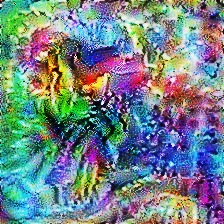

Starting iteration 25


100%|██████████| 512/512 [00:08<00:00, 63.58it/s]



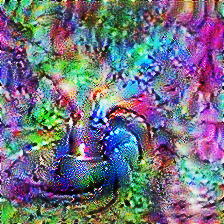

Starting iteration 54


100%|██████████| 512/512 [00:08<00:00, 63.29it/s]



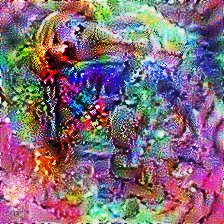

Starting iteration 89


100%|██████████| 512/512 [00:08<00:00, 63.20it/s]



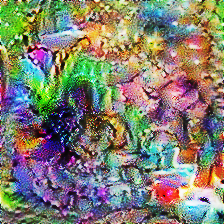

Starting iteration 131


100%|██████████| 512/512 [00:08<00:00, 62.88it/s]



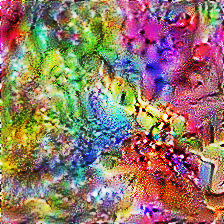

Starting iteration 200


100%|██████████| 512/512 [00:08<00:00, 62.84it/s]



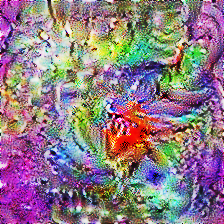

Starting iteration 221


100%|██████████| 512/512 [00:08<00:00, 63.04it/s]



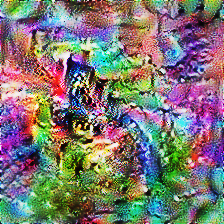

Starting iteration 276


100%|██████████| 512/512 [00:08<00:00, 62.35it/s]



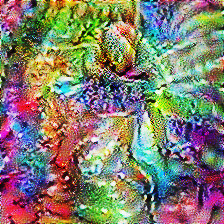

Starting iteration 340


100%|██████████| 512/512 [00:08<00:00, 61.83it/s]



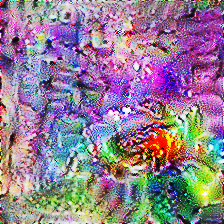

Starting iteration 455


100%|██████████| 512/512 [00:08<00:00, 62.17it/s]



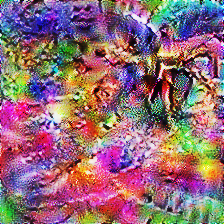

Starting iteration 500


100%|██████████| 512/512 [00:08<00:00, 62.02it/s]


In [ ]:
def visualize_with_lucent(layer, channels):
    alub_dir = 'Alub/' + layer
    if not os.path.exists(alub_dir):
      os.makedirs(alub_dir)

    for i in (channels):
      print(f"Starting iteration {i}")
      layer_name = layer + ':' + str(i)
      alub_image = render.render_vis(model, layer_name, param_f_alub, preprocess=False, show_inline=True)
      plt.imshow(alub_image[0][0, :, :, 0:3])
      plt.axis('off')  # To turn off the axis, making the image cleaner
      plt.savefig((alub_dir + '/' + str(i) + '.png'), bbox_inches='tight', pad_inches=0)
      plt.close()

neurons = [8, 25, 54, 89, 131, 200, 221, 276, 340, 455, 500]
visualize_with_lucent('layer4_1_conv2', neurons)

In [ ]:
!zip -r alub_layer4_1_conv2.zip Alub/layer4_1_conv2/

  adding: Alub/layer4_1_conv2/ (stored 0%)
  adding: Alub/layer4_1_conv2/500.png (deflated 0%)
  adding: Alub/layer4_1_conv2/8.png (deflated 0%)
  adding: Alub/layer4_1_conv2/25.png (deflated 0%)
  adding: Alub/layer4_1_conv2/200.png (deflated 0%)
  adding: Alub/layer4_1_conv2/89.png (deflated 0%)
  adding: Alub/layer4_1_conv2/221.png (deflated 0%)
  adding: Alub/layer4_1_conv2/54.png (deflated 0%)
  adding: Alub/layer4_1_conv2/455.png (deflated 0%)
  adding: Alub/layer4_1_conv2/131.png (deflated 0%)
  adding: Alub/layer4_1_conv2/340.png (deflated 0%)
  adding: Alub/layer4_1_conv2/276.png (deflated 0%)


In [ ]:
from google.colab import files
files.download('alub_layer4_1_conv2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('alub.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('inference_data_loop_1.csv')
files.download('inference_data_loop_2.csv')
files.download('inference_data_loop_3.csv')
files.download('inference_data_loop_4.csv')
files.download('inference_data_loop_5.csv')
files.download('inference_data_loop_6.csv')
files.download('inference_data_loop_7.csv')
files.download('inference_data_loop_8.csv')
files.download('inference_data_loop_9.csv')
files.download('inference_data_loop_10.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# RELOAD

In [ ]:
num_classes = 200

# Define the model architecture
model = models.resnet18(num_classes)  # Adjust the number of classes as needed
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the pre-trained weights
model.load_state_dict(torch.load('alub.pth'))

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
data_dir = '/content/tiny-imagenet-200/'
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
correct_per_class = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 0.68%


In [ ]:
import os
import shutil
from torchvision.datasets import ImageFolder

# Define paths
data_dir = '/content/tiny-imagenet-200/'
val_dir = os.path.join(data_dir, 'val')

# Load validation annotations
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')
val_images_dir = os.path.join(val_dir, 'images')

# Create directories for validation images by class
with open(val_annotations_file, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        img_file = parts[0]
        class_label = parts[1]
        class_dir = os.path.join(val_images_dir, class_label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        shutil.move(os.path.join(val_images_dir, img_file), os.path.join(class_dir, img_file))

# Load the validation dataset
val_dataset = ImageFolder(root=val_images_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model architecture
num_classes = 200
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the pre-trained weights
model.load_state_dict(torch.load('alub.pth'))

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()  # Set the model to evaluation mode

correct_per_class = np.zeros(num_classes)
total_per_class = np.zeros(num_classes)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for label, prediction in zip(labels, predicted):
            label = label.item()
            prediction = prediction.item()
            if label == prediction:
                correct_per_class[label] += 1
            total_per_class[label] += 1

            # # Debugging prints
            # print(f"Label: {label}, Prediction: {prediction}, Correct: {correct_per_class[label]}, Total: {total_per_class[label]}")

# Calculate per-class accuracy and handle division by zero
per_class_accuracy = np.divide(correct_per_class, total_per_class, out=np.zeros_like(correct_per_class), where=total_per_class!=0)

# Print per-class accuracy
for i, accuracy in enumerate(per_class_accuracy):
    print(f'Class {i}: Accuracy: {accuracy * 100:.2f}%')


Class 0: Accuracy: 84.00%
Class 1: Accuracy: 64.00%
Class 2: Accuracy: 66.00%
Class 3: Accuracy: 26.00%
Class 4: Accuracy: 42.00%
Class 5: Accuracy: 30.00%
Class 6: Accuracy: 58.00%
Class 7: Accuracy: 32.00%
Class 8: Accuracy: 64.00%
Class 9: Accuracy: 54.00%
Class 10: Accuracy: 28.00%
Class 11: Accuracy: 40.00%
Class 12: Accuracy: 68.00%
Class 13: Accuracy: 72.00%
Class 14: Accuracy: 58.00%
Class 15: Accuracy: 46.00%
Class 16: Accuracy: 36.00%
Class 17: Accuracy: 42.00%
Class 18: Accuracy: 34.00%
Class 19: Accuracy: 56.00%
Class 20: Accuracy: 62.00%
Class 21: Accuracy: 50.00%
Class 22: Accuracy: 70.00%
Class 23: Accuracy: 82.00%
Class 24: Accuracy: 32.00%
Class 25: Accuracy: 42.00%
Class 26: Accuracy: 48.00%
Class 27: Accuracy: 28.00%
Class 28: Accuracy: 44.00%
Class 29: Accuracy: 38.00%
Class 30: Accuracy: 38.00%
Class 31: Accuracy: 72.00%
Class 32: Accuracy: 30.00%
Class 33: Accuracy: 30.00%
Class 34: Accuracy: 28.00%
Class 35: Accuracy: 58.00%
Class 36: Accuracy: 74.00%
Class 37: A

In [ ]:
# Remove the directory using shell command
!rm -r //content/tiny-imagenet-200

# ORTHAGONALITY IN FEATURES

In [ ]:
num_classes = 200

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load validation dataset
data_dir = '/content/tiny-imagenet-200/'
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define a function to modify the model to extract features from a specific layer
def get_feature_extractor(model, layer_name):
    layer = dict([*model.named_modules()])[layer_name]
    feature_extractor = nn.Sequential(*list(model.children())[:list(model.children()).index(layer) + 1])
    return feature_extractor

# Define a function to extract features
def extract_features(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())

    features = np.concatenate(features)
    print(f"Extracted features shape: {features.shape}")
    return features

# Load the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

#baseline_model = load_model('baseline.pth')
alub_model = load_model('alub.pth')

# Extract features
layer_name = 'layer4'
#baseline_features = extract_features(baseline_model, val_loader, layer_name)
alub_features = extract_features(alub_model, val_loader, layer_name)

Extracted features shape: (10000, 512, 7, 7)


In [ ]:
# print("Baseline features statistics:")
# print(f"Mean: {baseline_features.mean()}, Std: {baseline_features.std()}")

print("Active Learning features statistics:")
print(f"Mean: {alub_features.mean()}, Std: {alub_features.std()}")


Active Learning features statistics:
Mean: 0.49109625816345215, Std: 1.1031250953674316


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def compute_cosine_similarity(features):
    features_flat = features.reshape(features.shape[0], -1)  # Flatten feature vectors
    cos_sim = cosine_similarity(features_flat)
    return cos_sim

# baseline_cos_sim = compute_cosine_similarity(baseline_features)
alub_cos_sim = compute_cosine_similarity(alub_features)


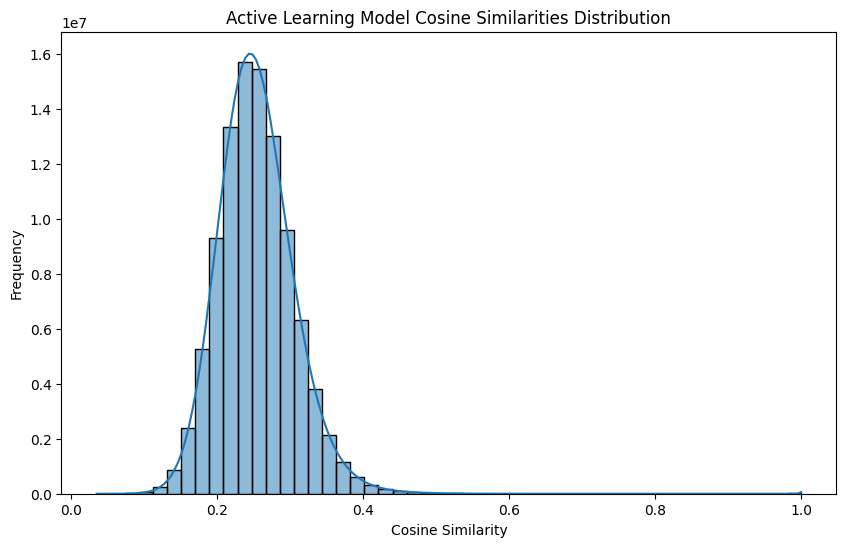

In [ ]:
def plot_cosine_similarity_distribution(cos_sim, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(cos_sim.flatten(), bins=50, kde=True)
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

# plot_cosine_similarity_distribution(baseline_cos_sim, 'Baseline Model Cosine Similarities Distribution')
plot_cosine_similarity_distribution(alub_cos_sim, 'Active Learning Model Cosine Similarities Distribution')


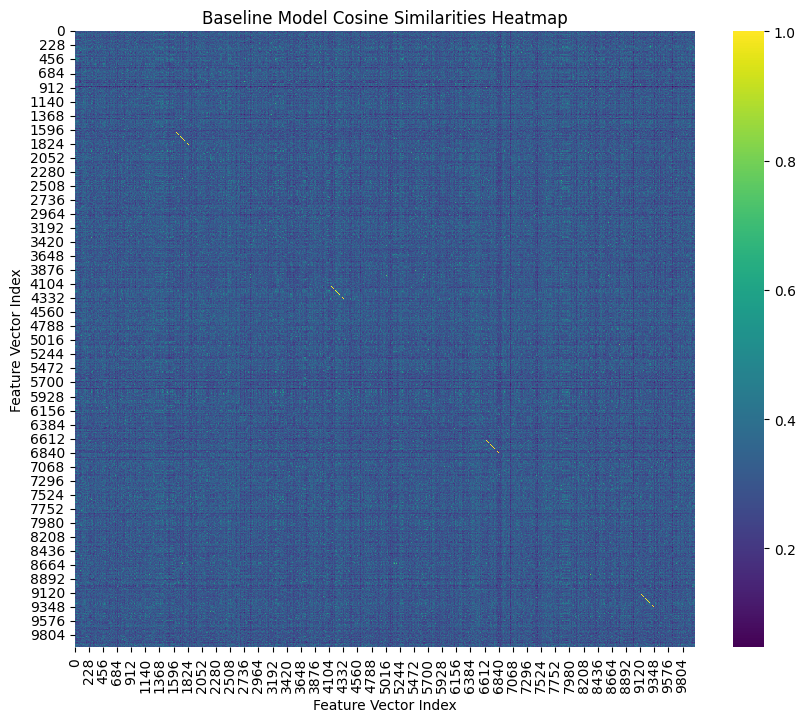

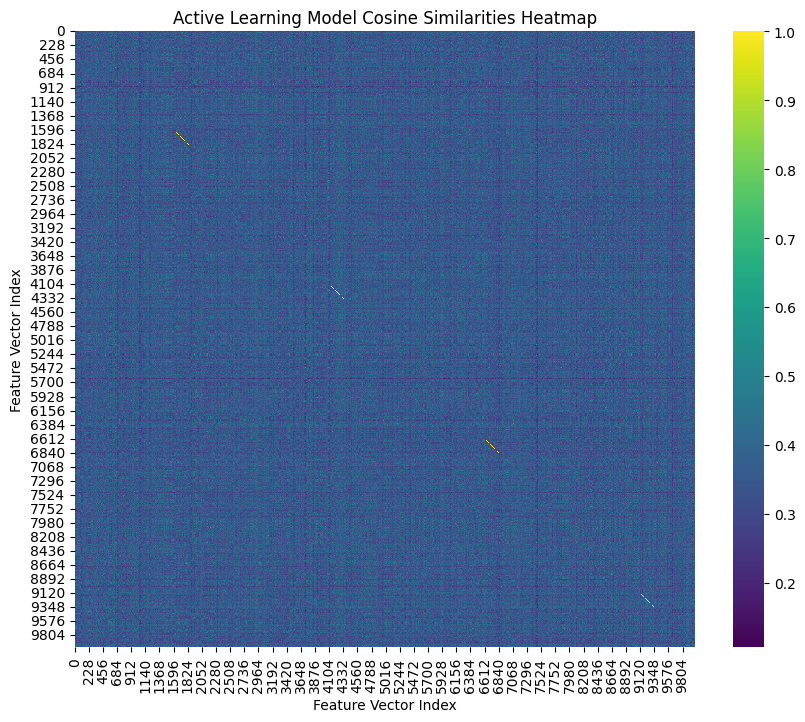

In [ ]:
# Function to plot cosine similarity heatmaps
def plot_cosine_similarity_heatmap(cos_sim, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim, cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel('Feature Vector Index')
    plt.ylabel('Feature Vector Index')
    plt.show()

# Plot heatmaps
plot_cosine_similarity_heatmap(baseline_cos_sim, 'Baseline Model Cosine Similarities Heatmap')
plot_cosine_similarity_heatmap(alub_cos_sim, 'Active Learning Model Cosine Similarities Heatmap')

In [ ]:
def percentage_near_zero(cos_sim, threshold=0.1):
    num_elements = cos_sim.size
    near_zero = np.sum(cos_sim < threshold)
    return (near_zero / num_elements) * 100

#baseline_near_zero_percentage = percentage_near_zero(baseline_cos_sim)
alub_near_zero_percentage = percentage_near_zero(alub_cos_sim)

#print(f"Baseline Model - Percentage of Cosine Similarities < 0.1: {baseline_near_zero_percentage:.2f}%")
print(f"Active Learning Model - Percentage of Cosine Similarities < 0.1: {alub_near_zero_percentage:.2f}%")


Active Learning Model - Percentage of Cosine Similarities < 0.1: 0.03%


In [ ]:
def compute_cosine_similarity_statistics(cos_sim):
    mean = np.mean(cos_sim)
    std = np.std(cos_sim)
    min_val = np.min(cos_sim)
    max_val = np.max(cos_sim)
    quantiles = np.percentile(cos_sim, [25, 50, 75])

    return {
        "mean": mean,
        "std": std,
        "min": min_val,
        "max": max_val,
        "25th_percentile": quantiles[0],
        "50th_percentile": quantiles[1],
        "75th_percentile": quantiles[2]
    }

# baseline_stats = compute_cosine_similarity_statistics(baseline_cos_sim)
alub_stats = compute_cosine_similarity_statistics(alub_cos_sim)

# print("Baseline Model Cosine Similarity Statistics:", baseline_stats)
print("Active Learning Model Cosine Similarity Statistics:", alub_stats)


Active Learning Model Cosine Similarity Statistics: {'mean': 0.25409868, 'std': 0.051403128, 'min': 0.035167746, 'max': 1.0000014, '25th_percentile': 0.21936268731951714, '50th_percentile': 0.25085094571113586, '75th_percentile': 0.2849442958831787}


In [ ]:
# Load the model and set to evaluation mode
num_classes = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

model = load_model('alub.pth')
model.eval()

# Define transformations and load validation dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/content/tiny-imagenet-200'
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Feature extraction function
def get_feature_extractor(model, layer_name):
    layer = dict([*model.named_modules()])[layer_name]
    feature_extractor = torch.nn.Sequential(*list(model.children())[:list(model.children()).index(layer) + 1])
    return feature_extractor

def extract_features(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Extract features and labels from the specified layer
layer_name = 'layer4'
features, labels = extract_features(model, val_loader, layer_name)
features = features.reshape(features.shape[0], -1)  # Flatten feature vectors


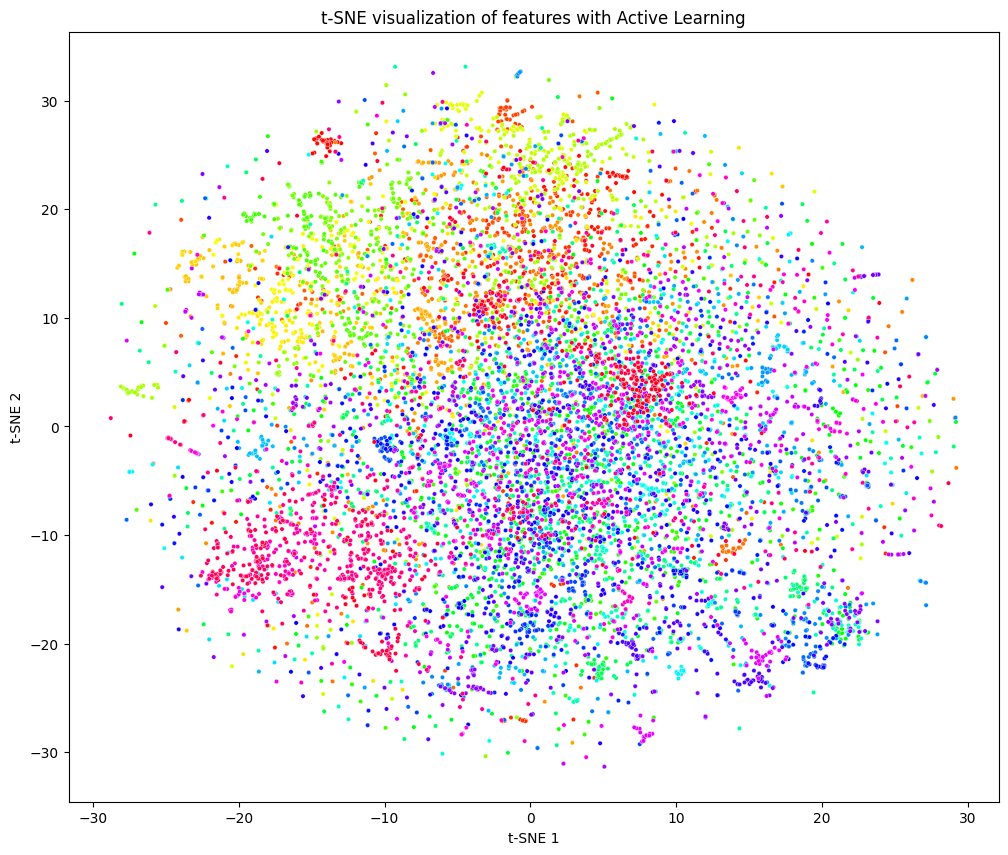

Active Learning Model - Silhouette Score: -0.3990049660205841, Davies-Bouldin Index: 34.60666668070504


In [ ]:
import os
import shutil
from pathlib import Path

# Paths
val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Ensure each class folder inside images contains images
for class_dir in os.listdir(val_images_dir):
    class_path = os.path.join(val_images_dir, class_dir)
    # if os.path.isdir(class_path):
    #     print(f"Class {class_dir} contains {len(os.listdir(class_path))} images.")
    # else:
    #     print(f"Skipping non-directory {class_dir}.")

# Verify the dataset loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder
val_dataset = datasets.ImageFolder(root=val_images_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# # Print the class-to-index mapping to verify
# print("\nClass-to-index mapping:")
# print(val_dataset.class_to_idx)

# Function to extract features and check labels during the process
def extract_features_with_label_check(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())
            #print("Batch labels:", label)  # Print labels for each batch

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Function to get the feature extractor up to a specific layer
def get_feature_extractor(model, layer_name):
    layer = dict([*model.named_modules()])[layer_name]
    feature_extractor = torch.nn.Sequential(*list(model.children())[:list(model.children()).index(layer) + 1])
    return feature_extractor

# Load the model and set to evaluation mode
num_classes = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

model = load_model('alub.pth')
model.eval()

# Extract features and labels from the specified layer
layer_name = 'layer4'
features, labels = extract_features_with_label_check(model, val_loader, layer_name)
features = features.reshape(features.shape[0], -1)  # Flatten feature vectors

# Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot t-SNE embeddings with correct hue
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the color palette has enough colors
palette = sns.color_palette("hsv", len(np.unique(labels)))

# Plot t-SNE embeddings with correct hue
plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=palette, legend=None, s=10)

plt.title('t-SNE visualization of features with Active Learning')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.show()


from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score
silhouette_active = silhouette_score(tsne_features, labels)
db_active = davies_bouldin_score(tsne_features, labels)

print(f'Active Learning Model - Silhouette Score: {silhouette_active}, Davies-Bouldin Index: {db_active}')

In [ ]:
import os
import shutil
from pathlib import Path

# Paths
val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Ensure each class folder inside images contains images
for class_dir in os.listdir(val_images_dir):
    class_path = os.path.join(val_images_dir, class_dir)
    # if os.path.isdir(class_path):
    #     print(f"Class {class_dir} contains {len(os.listdir(class_path))} images.")
    # else:
    #     print(f"Skipping non-directory {class_dir}.")

# Verify the dataset loading
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder
val_dataset = datasets.ImageFolder(root=val_images_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# # Print the class-to-index mapping to verify
# print("\nClass-to-index mapping:")
# print(val_dataset.class_to_idx)

# Function to extract features and check labels during the process
def extract_features_with_label_check(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())
            #print("Batch labels:", label)  # Print labels for each batch

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Function to get the feature extractor up to a specific layer
def get_feature_extractor(model, layer_name):
    layer = dict([*model.named_modules()])[layer_name]
    feature_extractor = torch.nn.Sequential(*list(model.children())[:list(model.children()).index(layer) + 1])
    return feature_extractor

# Load the model and set to evaluation mode
num_classes = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

model = load_model('baseline.pth')
model.eval()

# Extract features and labels from the specified layer
layer_name = 'layer4'
features, labels = extract_features_with_label_check(model, val_loader, layer_name)
features = features.reshape(features.shape[0], -1)  # Flatten feature vectors

# Apply t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# # Plot t-SNE embeddings with correct hue
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure the color palette has enough colors
# palette = sns.color_palette("hsv", len(np.unique(labels)))

# # Plot t-SNE embeddings with correct hue
# plt.figure(figsize=(12, 10))
# sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=palette, legend=None, s=10)

# plt.title('t-SNE visualization of features for Baseline')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')

# plt.show()

from sklearn.metrics import silhouette_score, davies_bouldin_score
# Calculate silhouette score
silhouette_base = silhouette_score(tsne_features, labels)
db_base = davies_bouldin_score(tsne_features, labels)

print(f'Baseline Model - Silhouette Score: {silhouette_base}, Davies-Bouldin Index: {db_base}')


Baseline Model - Silhouette Score: -0.34884706139564514, Davies-Bouldin Index: 19.14117443842235


For Neuron 8


100%|██████████| 512/512 [00:08<00:00, 63.78it/s]



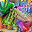

For Neuron 25


100%|██████████| 512/512 [00:07<00:00, 66.41it/s]



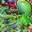

For Neuron 54


100%|██████████| 512/512 [00:07<00:00, 66.99it/s]



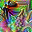

For Neuron 89


100%|██████████| 512/512 [00:07<00:00, 67.26it/s]



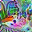

For Neuron 131


100%|██████████| 512/512 [00:07<00:00, 66.26it/s]



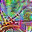

For Neuron 200


100%|██████████| 512/512 [00:07<00:00, 66.23it/s]



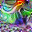

For Neuron 221


100%|██████████| 512/512 [00:07<00:00, 65.53it/s]



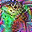

For Neuron 276


100%|██████████| 512/512 [00:07<00:00, 64.05it/s]



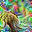

For Neuron 340


100%|██████████| 512/512 [00:07<00:00, 64.45it/s]



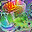

For Neuron 455


100%|██████████| 512/512 [00:07<00:00, 64.10it/s]



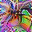

For Neuron 500


100%|██████████| 512/512 [00:07<00:00, 64.38it/s]



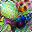

In [ ]:
num_classes = 200

# Define the model architecture
model = models.resnet18(num_classes)  # Adjust the number of classes as needed
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the pre-trained weights
model.load_state_dict(torch.load('alub.pth'))

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

param_f_cif = lambda : lucent.optvis.param.image(32, channels=3)

def visualize_with_lucent(layer, channels):
    tiny_dir = 'tiny/' + layer
    if not os.path.exists(tiny_dir):
      os.makedirs(tiny_dir)

    for i in (channels):
      print(f"For Neuron {i}")
      layer_name = layer + ':' + str(i)
      alub_image = render.render_vis(model, layer_name, param_f_cif, preprocess=False, show_inline=True)
      plt.imshow(alub_image[0][0, :, :, 0:3])
      plt.axis('off')  # To turn off the axis, making the image cleaner
      plt.savefig((tiny_dir + '/' + str(i) + '.png'), bbox_inches='tight', pad_inches=0)
      plt.close()

neurons = [8, 25, 54, 89, 131, 200, 221, 276, 340, 455, 500]
visualize_with_lucent('layer4_1_conv2', neurons)